# Modelo de ML: Rede Neural LSTM

## Configurações iniciais

In [115]:
# Importações de libraries importantes
import pandas as pd
import numpy as np
import pickle as pl
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Dense, Dropout

In [164]:
# Carregamento de datasets processados
X_train = pl.load(open('../data/processed/X_train.pkl', 'rb'))
X_train_deploy = pl.load(open('../data/processed/X_train_deploy.pkl', 'rb'))
X_test = pl.load(open('../data/processed/X_test.pkl', 'rb'))
Y_train = pl.load(open('../data/processed/Y_train.pkl', 'rb'))
Y_test = pl.load(open('../data/processed/Y_test.pkl', 'rb'))

## Construção do Modelo

In [75]:
modelo = Sequential()

### Camadas de Entrada

In [76]:
# Camada de embedding que transforma as sequências em vetores densos

dimensao_embedding = 32
tamanho_frases = 250
vocabulario_tamanho = 13000

modelo.add(Embedding(vocabulario_tamanho, dimensao_embedding, input_length=tamanho_frases))

### Camadas Escondidas

In [77]:
# Camada LSTM bidirecional para poder relembrar tanto passado --> futuro quanto futuro --> passado

neuronios = 32
modelo.add(Bidirectional(LSTM(neuronios)))

# Camada dropout

modelo.add(Dropout(0.1))

### Camadas de Saída

In [78]:
# Camada densa que passa a saída (output)
modelo.add(Dense(16, activation='relu'))
modelo.add(Dense(1, activation='sigmoid'))

## Sumário do Modelo

In [79]:
modelo.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 250, 32)           416000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 433,697
Trainable params: 433,697
Non-trainable params: 0
________________________________________________

## Compilação e Treinamento do Modelo 

In [80]:
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
now = datetime.datetime.now()
modelo_ = modelo.fit(X_train, Y_train, epochs=4, validation_data=(X_test, Y_test), verbose=3, batch_size=5)

now2 = datetime.datetime.now()
time = now2 - now

print(f"O tempo que levou para treinar é de {time}")

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
O tempo que levou para treinar é de 0:31:44.801911


## Avaliação do Modelo

In [83]:
history = pd.DataFrame(modelo_.history)
history

,loss,accuracy,val_loss,val_accuracy
0,0.389602,0.832212,0.440385,0.810000
1,0.248570,0.903341,0.281084,0.882133
2,0.198446,0.926259,0.275907,0.891200
3,0.154170,0.945529,0.291218,0.894933


In [84]:
y_pred = modelo.predict(X_test)
y_pred = np.array(list(map(lambda x: 1 if x > 0.5 else 0, y_pred)))
y_pred

235/235 [==============================] - 8s 22ms/step


array([0, 0, 1, ..., 1, 1, 0])

In [85]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3755
           1       0.90      0.89      0.89      3745

    accuracy                           0.89      7500
   macro avg       0.90      0.89      0.89      7500
weighted avg       0.90      0.89      0.89      7500



In [177]:
def plotar_dados(titulo, train, val, ylabel):
    
    sns.set()
    ax, fig = plt.subplots(figsize=(8, 5))
    # Linhas de treinamento e teste
    fig.plot(history.index, history[train], label="Treinamento")
    fig.plot(history.index, history[val], label="Validação")
    #Títulos
    plt.xlabel("Épocas")
    plt.title(titulo)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

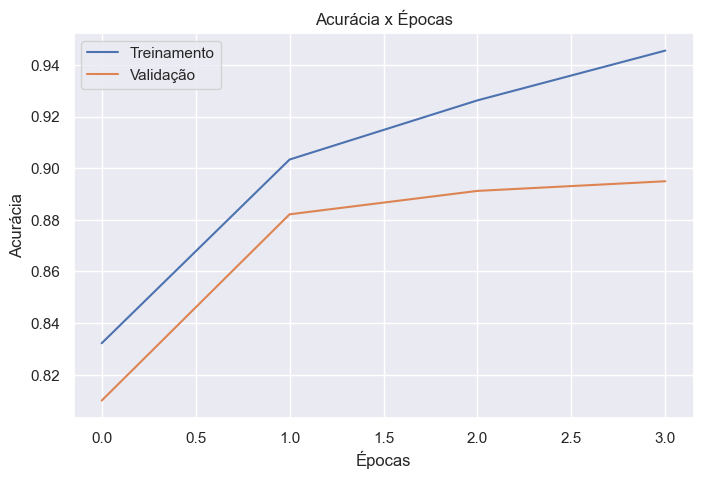

In [178]:
plotar_dados("Acurácia x Épocas", "accuracy", "val_accuracy", "Acurácia")

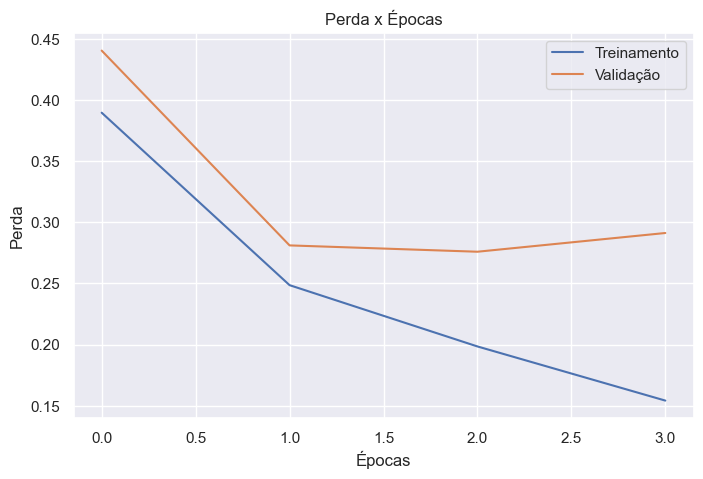

In [179]:
plotar_dados("Perda x Épocas", "loss", "val_loss", "Perda")

## Avaliação Prática 

In [167]:
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prep_dados(texto: str):
    
    # Limpa o texto (remove alfanuméricos, simbolos, etc.)
    texto = re.sub(r'[^a-zA-Z0-9\s]', '', texto)
    texto = texto.lower()
    
    #Remove palavras desnecessárias
    stopwords_ = set(stopwords.words('english'))
    ma = lambda x: ' '.join([word for word in x.split() if word not in (stopwords_)])
    dados_prep = ma(texto)
    
    # Lematiza o texto (pega somente a raiz das palavras)
    tokenizador = nltk.tokenize.WhitespaceTokenizer()
    lematizador = nltk.stem.WordNetLemmatizer()
        
    st = ""
        
    for palavra in tokenizador.tokenize(dados_prep):
        st = st + lematizador.lemmatize(palavra) + " "
    
    
    # Tranforma em array do numpy
    dados_prep = np.array([dados_prep])
    
    # Tokeniza
    
    vocabulario_tamanho = 13000
    oov_tok = "<OOV>"
    tokenizador = Tokenizer(num_words=vocabulario_tamanho, oov_token=oov_tok)
    tokenizador.fit_on_texts(X_train_deploy)
    dados_prep = tokenizador.texts_to_sequences(dados_prep)
    
    # Padding para adequar o tamanho da sequência
    tamanho_frase = len(dados_prep[0])
    dados_prep = pad_sequences(dados_prep, maxlen=tamanho_frase, padding='post', truncating='post')
    
    return dados_prep
    

In [176]:
negativo = prep_dados("Terrible movie I hated I could vomit disgusting terrible terrible ass watching.")
positivo = prep_dados("So lovely, beautiful, love, I could watch it everytime, beautiful image.")
neutro = prep_dados("not Bad It was normal, I liked it partially!!!!!!")

print(f"O valor da predição para a frase negativa é: {modelo.predict(negativo)[0][0]}")
print(f"O valor da predição para a frase positiva é: {modelo.predict(positivo)[0][0]}")
print(f"O valor da predição para a frase neutra é: {modelo.predict(neutro)[0][0]}")

1/1 [==============================] - 1s 1s/step
O valor da predição para a frase negativa é: 0.3836265206336975
1/1 [==============================] - 1s 890ms/step
O valor da predição para a frase positiva é: 0.7359124422073364
1/1 [==============================] - 1s 1s/step
O valor da predição para a frase neutra é: 0.5178763270378113


## Serialização do Modelo 

In [174]:
# Salva o modelo treinado no formato pickle
pl.dump(modelo, open('../models/modelo.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\embedding
......vars
.........0
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........3
.........4
.........5
........